# PFlow graphs

This notebook demonstrates the use of graphs in `PFlow`. We use the following libraries:

In [1]:
using LightGraphs, GraphPlot, DataFrames, SimJulia
using Revise # only for development purposes
using PFlow

INFO: Recompiling stale cache file /Users/paul/.julia/lib/v0.6/StatsBase.ji for module StatsBase.
INFO: Recompiling stale cache file /Users/paul/.julia/lib/v0.6/DataFrames.ji for module DataFrames.
INFO: Recompiling stale cache file /Users/paul/.julia/lib/v0.6/SimJulia.ji for module SimJulia.
INFO: Recompiling stale cache file /Users/paul/.julia/lib/v0.6/Distributions.ji for module Distributions.


## Order flow

In `PFlow` we define orders in simple `.csv`-files, eg.: 

In [2]:
orderfile = "../../models/MOD01_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,5.0,1,NA
2,ORD01,JOB02,"MC02,MC03,MC04",8.0,1,NA
3,ORD01,JOB03,MC05,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


The `.csv` file contains two orders: `ORD01` and `ORD02`. From it `PFlow` constructs a dictionary containing the jobs of each order: 

In [3]:
d = readOrders(orderfile)

Dict{String,Array{PFlow.Job,1}} with 2 entries:
  "ORD02" => PFlow.Job[PFlow.Job(0, "JOB01", String["MC01"], 4.0, 0.0, 0.0, 0, …
  "ORD01" => PFlow.Job[PFlow.Job(0, "JOB01", String["MC01"], 5.0, 0.0, 0.0, 0, …

If orders are defined, they establish a flow through a production system. Using the above order dictionary we can display the order graph, showing the possible flow paths of orders through the production system. Order 1 (`ORD01`) establishes the following flow:

HTML{String}("<h3>Order graph for ORD01</h3>")

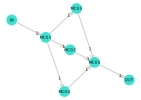

In [4]:
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d, "ORD01")
display(HTML("<h3>Order graph for ORD01</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

… or for `ORD02`:

HTML{String}("<h3>Order graph for ORD02</h3>")

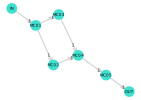

In [5]:
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d, "ORD02")
display(HTML("<h3>Order graph for ORD02</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

If we don't select for an order, we get a combined order graph, showing the flow paths of multiple orders through the system.

HTML{String}("<h3>Combined order graph</h3>")

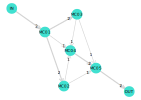

In [6]:
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d)
display(HTML("<h3>Combined order graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Now the edges have different weights, showing how many orders use that edge.

## Product flow

How many products pass over each edge and what this means for the workload of the work units involved, depends on many factors such as

- number of products scheduled for each order,
- scheduling strategy (batch or leveled),
- processing times,
- characteristics of the work units (variation in processing times and failures),
- chance.

Therefore it has to be established by simulation. We schedule 7 products of `ORD01` and 18 of `ORD02` and create a leveled master production schedule: 

In [7]:
plan1 = Planned(123,  7, 123000, "Order 1", "Order 1 description", "ORD01")
plan2 = Planned(456, 18, 456000, "Order 2", "Order 2 description", "ORD02")
mps = create_mps([plan1, plan2], d);

Then we read in the work units, which are defined in a `.csv` file:

In [8]:
wufile = "../../models/MOD01_workunits.csv"
tab = readtable(wufile)

,name,description,kind,input,jobs,output,alpha,mtbf,mttr,timeslice
1,MC01,machining centre,1,1,1,1,100,500,10,0
2,MC02,machining centre,1,1,1,1,100,500,10,0
3,MC03,machining centre,1,1,1,1,100,500,10,0
4,MC04,machining centre,1,1,1,1,100,500,10,0
5,MC05,machining centre,1,1,1,1,100,500,10,0


Those are 5 machines (`kind = 1`) which each one `input`, `job` and `output` buffer, a slight variation (`alpha = 100`) in processing times, meantime between failures (`mtbf`) of 500 and meantime to repair (`mttr`) of 10. Timeslice for multitasking is not used.

If we read this file into `PFlow`, it creates from it five work unit processes waiting for work. Therefore we have to create our simulation variable `sim` first. 

In [9]:
srand(2345)  # seed random number generator for reproducibility
sim = Simulation()
wus = readWorkunits(wufile, sim);

Then we have to 
1. define a warehouse variable for finished products, 
2. start the scheduling on the simulation variable `sim`, the workunits `wus`, the master production schedule `mps` and the `finished` warehouse, and
3. run the simulation for 150 minutes.

In [10]:
finished = Products()
start_scheduling(sim, wus, mps, finished)
run(sim, 150)

In [11]:
res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
res

,item,code,name,order,starttime,endtime,leadtime
1,123001,123,Order 1,ORD01,0.0,17.82,17.82
2,456001,456,Order 2,ORD02,0.0,23.75,23.75
3,456002,456,Order 2,ORD02,0.0,31.13,31.13
4,123002,123,Order 1,ORD01,0.0,35.2,35.2
5,456003,456,Order 2,ORD02,0.0,39.71,39.71
6,456005,456,Order 2,ORD02,0.0,45.07,45.07
7,456004,456,Order 2,ORD02,0.0,49.39,49.39
8,456006,456,Order 2,ORD02,0.0,53.69,53.69
9,123003,123,Order 1,ORD01,0.0,57.75,57.75
10,456007,456,Order 2,ORD02,0.0,62.6,62.6


As expected, we got 25 finished products into the warehouse. We can see it on a flow diagram:

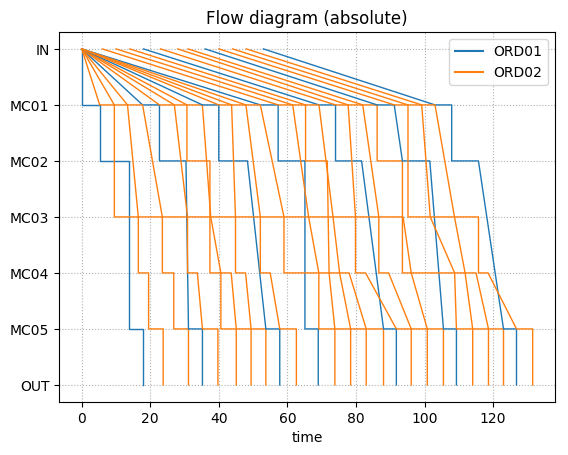

In [12]:
flow(finished, wus)

We can see from the diagram, that `MC02` and `MC04` were not working continuously and that products took different paths through the system. 

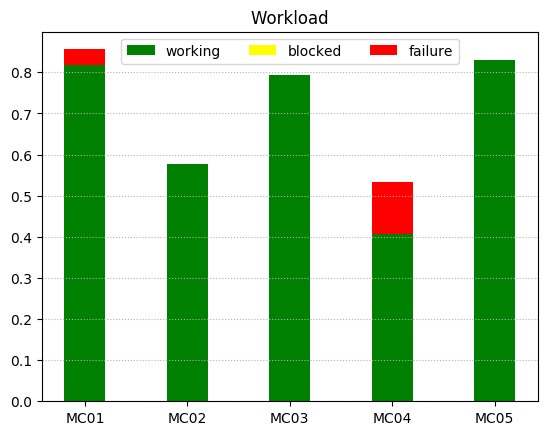

In [13]:
loadbars(wus, 132)

As we could guess from the order graphs above, `MC01` and `MC05` are system constraints as they have no compensating work units.

HTML{String}("<h3>Product flow graph</h3>")

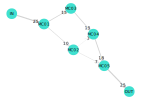

In [14]:
srand(2017) # for reproducibility
(G, nodes, weights) = flowgraph(finished)
display(HTML("<h3>Product flow graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

## Optimization

Let's use our most underused workunit `MC04` to relieve `MC05` by redefining jobs 2 and 3 in order 1:

In [15]:
orderfile = "../../models/MOD01a_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,5.0,1,NA
2,ORD01,JOB02,"MC02,MC03",8.0,1,NA
3,ORD01,JOB03,MC04,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


Our order graph now gets:

HTML{String}("<h3>Combined order graph</h3>")

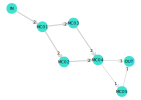

In [16]:
d = readOrders(orderfile)
srand(2017) # for reproducibility
(G, nodes, weights) = ordergraph(d)
display(HTML("<h3>Combined order graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Then we rerun the simulation and look at the leadtimes:

In [17]:
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = Simulation()
wus = readWorkunits(wufile, sim)
finished = Products()
start_scheduling(sim, wus, mps, finished)
run(sim, 150)
res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
tail(res)

,item,code,name,order,starttime,endtime,leadtime
1,123006,123,Order 1,ORD01,35.0,111.18,76.18
2,456014,456,Order 2,ORD02,28.0,111.78,83.78
3,456016,456,Order 2,ORD02,40.0,118.94,78.94
4,123007,123,Order 1,ORD01,52.0,121.43,69.43
5,456017,456,Order 2,ORD02,44.0,123.21,79.21
6,456018,456,Order 2,ORD02,48.0,129.28,81.28


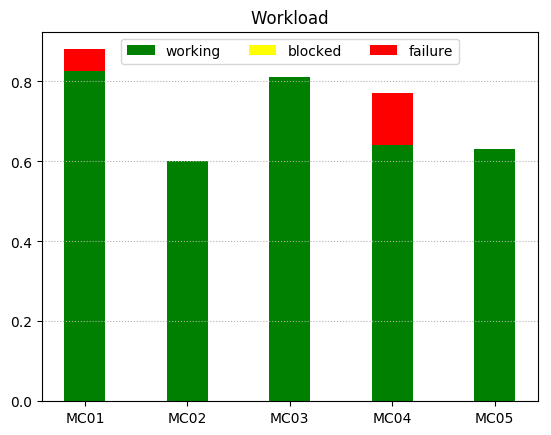

In [18]:
loadbars(wus, 129)

There is only a slight improvement in leadtime. Everything is determined by the now clear bottleneck `MC01`. Therefore we relieve the workload of `MC01` by moving 1 minute of `ORD01-JOB01` to `ORD01-JOB02`: 

In [19]:
orderfile = "../../models/MOD01b_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,4.0,1,NA
2,ORD01,JOB02,"MC02,MC03",9.0,1,NA
3,ORD01,JOB03,MC04,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


When we rerun the simulation, we should expect at least a 7 minute improvement in leadtime.

In [20]:
d = readOrders(orderfile)
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = Simulation()
wus = readWorkunits(wufile, sim)
finished = Products()
start_scheduling(sim, wus, mps, finished)
run(sim, 150)
res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
tail(res)

,item,code,name,order,starttime,endtime,leadtime
1,123006,123,Order 1,ORD01,33.0,101.13,68.13
2,456015,456,Order 2,ORD02,29.0,103.22,74.22
3,456016,456,Order 2,ORD02,37.0,108.56,71.56
4,456018,456,Order 2,ORD02,45.0,113.35,68.35
5,123007,123,Order 1,ORD01,49.0,116.44,67.44
6,456017,456,Order 2,ORD02,41.0,117.53,76.53


Nice, we got 12 minutes!

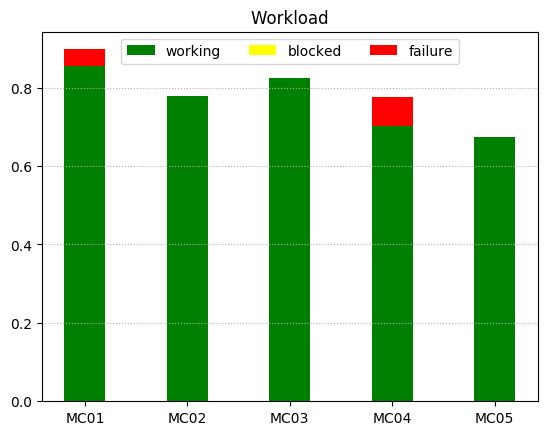

In [21]:
loadbars(wus, 118)

Let's move another 0.5 minutes:

In [22]:
orderfile = "../../models/MOD01c_orders.csv"
tab = readtable(orderfile)

,order,job,workunits,plan_time,batch_size,target
1,ORD01,JOB01,MC01,3.5,1,NA
2,ORD01,JOB02,"MC02,MC03",9.5,1,NA
3,ORD01,JOB03,MC04,4.0,1,NA
4,ORD02,JOB01,MC01,4.0,1,NA
5,ORD02,JOB02,"MC03,MC02",7.0,1,NA
6,ORD02,JOB03,MC04,3.0,1,NA
7,ORD02,JOB04,MC05,4.5,1,NA


In [23]:
d = readOrders(orderfile)
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = Simulation()
wus = readWorkunits(wufile, sim)
finished = Products()
start_scheduling(sim, wus, mps, finished)
run(sim, 150)
res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
tail(res)

,item,code,name,order,starttime,endtime,leadtime
1,123006,123,Order 1,ORD01,32.0,100.46,68.46
2,456015,456,Order 2,ORD02,28.0,102.38,74.38
3,456017,456,Order 2,ORD02,40.0,107.97,67.97
4,456016,456,Order 2,ORD02,36.0,112.76,76.76
5,123007,123,Order 1,ORD01,48.0,113.64,65.64
6,456018,456,Order 2,ORD02,44.0,116.94,72.94


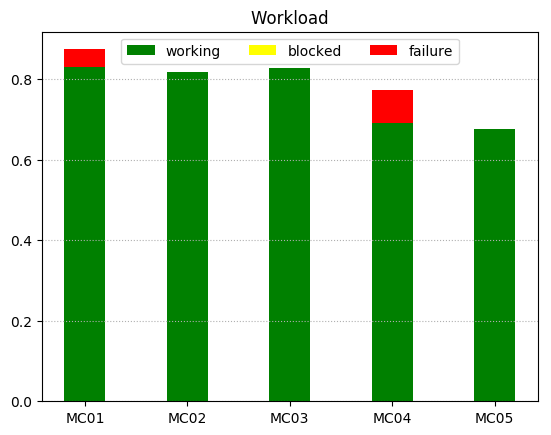

In [24]:
loadbars(wus, 118)

We got only slight improvements. It should be more fruitful, if we could utilize better the capacity of `MC04` and `MC05` ...

HTML{String}("<h3>Product flow graph</h3>")

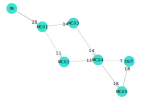

In [25]:
srand(2017) # for reproducibility
(G, nodes, weights) = flowgraph(finished)
display(HTML("<h3>Product flow graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))

Clearly, in a real world example, we would use much bigger orders and much longer simulation times to compensate for startup effects, failures and chance. 

Let's increase the demand and the simulation time by two orders of magnitude:

In [26]:
plan1 = Planned(123,  700, 123000, "Order 1", "Order 1 description", "ORD01")
plan2 = Planned(456, 1800, 456000, "Order 2", "Order 2 description", "ORD02")
mps = create_mps([plan1, plan2], d);
srand(2345)  # seed random number generator for reproducibility
sim = Simulation()
wus = readWorkunits(wufile, sim)
finished = Products()
start_scheduling(sim, wus, mps, finished)
run(sim, 10000)
res = leadtimetable(finished)
res[:starttime] = round.(res[:starttime], 2)
res[:endtime] = round.(res[:endtime], 2)
res[:leadtime] = round.(res[:leadtime], 2)
tail(res)

,item,code,name,order,starttime,endtime,leadtime
1,123695,123,Order 1,ORD01,9875.0,9964.33,89.33
2,123696,123,Order 1,ORD01,9879.0,9968.57,89.57
3,123697,123,Order 1,ORD01,9884.0,9972.79,88.79
4,123698,123,Order 1,ORD01,9889.0,9973.33,84.33
5,123699,123,Order 1,ORD01,9893.0,9979.01,86.01
6,123700,123,Order 1,ORD01,9899.0,9983.78,84.78


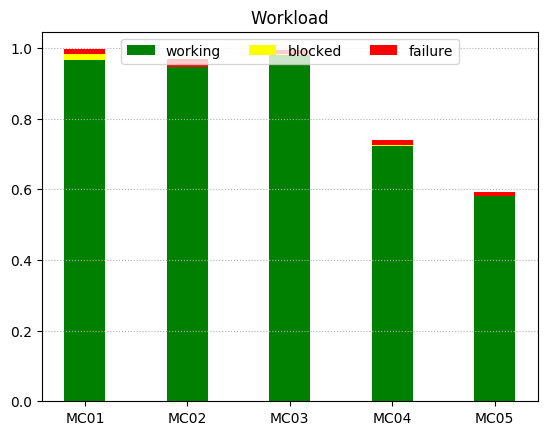

In [27]:
loadbars(wus, 10000)

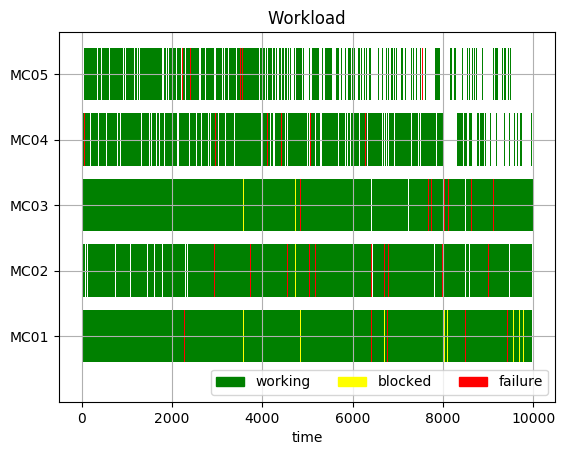

In [28]:
loadtime(wus)

HTML{String}("<h3>Product flow graph</h3>")

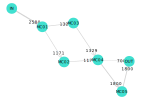

In [29]:
srand(2017) # for reproducibility
(G, nodes, weights) = flowgraph(finished)
display(HTML("<h3>Product flow graph</h3>"))
display(gplot(G, nodelabel=nodes, edgelabel=weights, edgelinewidth=weights))